# Import Required Libraries

In [1]:
!pip install rouge_score sumy -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 81.4 MB/s eta 0:00:00


In [2]:
import nltk
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
from transformers import  Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, T5ForConditionalGeneration, T5Tokenizer
import torch
from rouge_score import rouge_scorer
import os
import json
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

stopwords = set(nltk.corpus.stopwords.words('english')) - {"not", "no", "never", "none", "nobody", "nothing","neither", "nowhere", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "can't", "couldn't", "isn't", "aren't", "wasn't", "weren't", "without", "nor"}

2025-08-29 22:39:25.109018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756507165.307631      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756507165.373348      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Reading

In [3]:
# Dataset source: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/
train_data = pd.read_csv('/kaggle/input/cnn_dailymail/train.csv')
validation_data = pd.read_csv('/kaggle/input/cnn_dailymail/validation.csv')
test_data = pd.read_csv('/kaggle/input/cnn_dailymail/test.csv')

In [4]:
train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [5]:
print(f'Train Data Shape: {train_data.shape}')
print(f'Validation Data Shape: {validation_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

Train Data Shape: (287113, 3)
Validation Data Shape: (13368, 3)
Test Data Shape: (11490, 3)


### Limited training data & test data size used due to short resource capabilities. 

In [6]:
train_data = train_data[:40000]
test_data = test_data[:7500]

# Text Preprocessing

In [7]:
def preprocess_text(text: str):
    # 1. Convert text to lowercase
    def to_lower(text: str):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text: str):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub('http\S+', '', text)
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text: str):
        return word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    # Note: negative stopwords are not removed
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    return " ".join(tokens)

In [8]:
train_data['article'] = train_data['article'].apply(preprocess_text)
train_data['highlights'] = train_data['highlights'].apply(preprocess_text)

In [9]:
validation_data["article"] = validation_data["article"].apply(preprocess_text)
validation_data["highlights"] = validation_data["highlights"].apply(preprocess_text)

# Abstractive Summarization using T5 Transformer

In [10]:
tokenizer  = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Convert data from pandas to hugging face for integrated usage with theHugging Face Transformer

In [11]:
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_data = Dataset.from_pandas(train_data)
validation_data = Dataset.from_pandas(validation_data)
test_data = Dataset.from_pandas(test_data)

In [12]:
def tokenization(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    labels = tokenizer(
        examples["highlights"],
        max_length=512,
        truncation=True,
        padding="max_length"
        )

    labels_ids = labels["input_ids"]


    new_labels = []
    for label_seq in labels_ids:
        new_labels.append([
            (label if label != tokenizer.pad_token_id else -100) for label in label_seq
        ])

    model_inputs["labels"] = new_labels

    return model_inputs

In [13]:
tokenized_train = train_data.map(tokenization, batched=True, batch_size=32, remove_columns=["article", "highlights"])
tokenized_validation = validation_data.map(tokenization, batched=True, batch_size=32, remove_columns=["article", "highlights"])

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

## Load up the trainer

In [14]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_model_trainer",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.001,
    save_total_limit=3,
    num_train_epochs=7,
    report_to='none',
    predict_with_generate=True,
    no_cuda=False,
    dataloader_num_workers=0,
    fp16=True
)

In [15]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
)

In [16]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.834300,2.544255
2,2.778600,2.498024
3,2.758900,2.479360
4,2.715100,2.466879
5,2.694800,2.456643
6,2.691200,2.455072
7,2.677600,2.452806


TrainOutput(global_step=17500, training_loss=2.758466824776786, metrics={'train_runtime': 15249.3945, 'train_samples_per_second': 18.361, 'train_steps_per_second': 1.148, 'total_flos': 3.789570441216e+16, 'train_loss': 2.758466824776786, 'epoch': 7.0})

## Training Evaluation

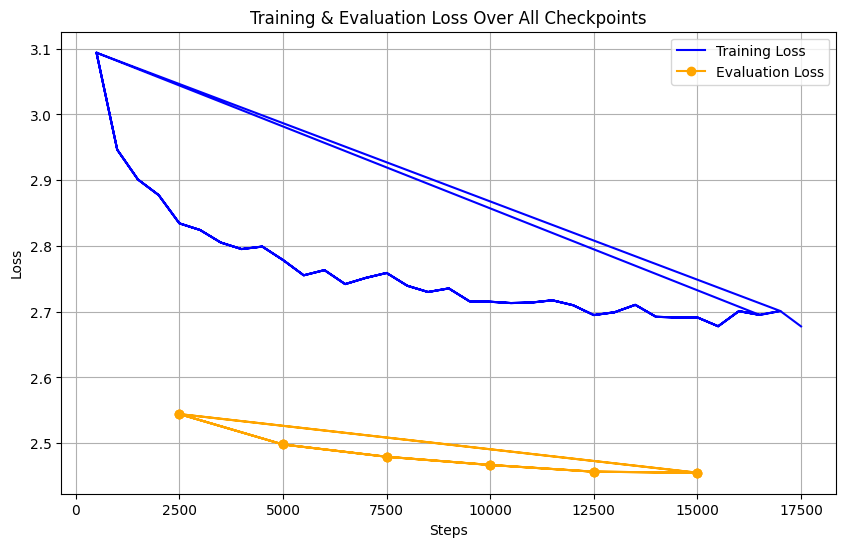

In [17]:
base_dir = r"t5_model_trainer"

steps, train_loss, eval_loss_steps, eval_loss_values = [], [], [], []


for folder in sorted(os.listdir(base_dir), key=lambda x: int(x.split("-")[-1]) if "-" in x else -1):
    folder_path = os.path.join(base_dir, folder)
    trainer_file = os.path.join(folder_path, "trainer_state.json")

    if os.path.isfile(trainer_file):
        with open(trainer_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        for entry in data.get("log_history", []):
            if "loss" in entry:
                steps.append(entry["step"])
                train_loss.append(entry["loss"])
            elif "eval_loss" in entry:
                eval_loss_steps.append(entry["step"])
                eval_loss_values.append(entry["eval_loss"])

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue")
plt.plot(eval_loss_steps, eval_loss_values, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss Over All Checkpoints")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
save_dir = "my_first_t5_text_summarizer"

tokenizer.save_pretrained(save_dir)
model.save_pretrained(save_dir)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def summarize_text(article):
    article = preprocess_text(article)

    inputs = tokenizer(
        article,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=150,
        min_length=30,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

def summarize_batch(examples):
    examples["predicted_summary"] = [summarize_text(article) for article in examples["article"]]
    return examples

test_data = test_data.map(summarize_batch, batched=True, batch_size=32)

Parameter 'function'=<function summarize_batch at 0x7e2b242f6e80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

## Show a portion of the test's results.

In [20]:
print("The Article:\n",test_data["article"][3])

The Article:
 Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. The Reds were linked with a move for the 25-year-old, whose contract expires in June, earlier in the season when Simon Mignolet was dropped from the side. A January move for Neto never materialised but the former Atletico Paranaense keeper looks certain to leave the Florence-based club in the summer. Neto rushes from his goal as Juan Iturbe bears down on him during Fiorentina's clash with Roma in March . Neto is wanted by a number of top European clubs including Liverpool and PSG, according to his agent . It had been reported that Neto had a verbal agreement to join Serie A champions Juventus at the end of the season but his agent has revealed no decision about his future has been made yet. And Castagna claims Neto will have his pick of top European clubs when the transfer window r

In [21]:
print(f"The Highlights:\n",test_data["highlights"][3])

The Highlights:
 Fiorentina goalkeeper Neto has been linked with Liverpool and Arsenal .
Neto joined Firoentina from Brazilian outfit Atletico Paranaense in 2011 .
He is also wanted by PSG and Spanish clubs, according to his agent .
CLICK HERE for the latest Liverpool news .


In [22]:
print(f"The Predicted Summary:\n",test_data["predicted_summary"][3])

The Predicted Summary:
 stefano castagna claims neto pick top european clubs transfer window reopens summer psg brendan rodgers faces stiff competition neto represented brazil london olympics


In [23]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_list = []
rouge2_list = []
rougeL_list = []

for ref, pred in zip(test_data["highlights"], test_data["predicted_summary"]):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougeL_list.append(scores['rougeL'].fmeasure)

print(f"Average ROUGE-1 F1: {sum(rouge1_list)/len(rouge1_list):.4f}")
print(f"Average ROUGE-2 F1: {sum(rouge2_list)/len(rouge2_list):.4f}")
print(f"Average ROUGE-L F1: {sum(rougeL_list)/len(rougeL_list):.4f}")

Average ROUGE-1 F1: 0.2696
Average ROUGE-2 F1: 0.0812
Average ROUGE-L F1: 0.2021


# Extractive Summarization using LexRank

In [24]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

summarizer = LexRankSummarizer()

parser = PlaintextParser.from_string(test_data['article'][3], Tokenizer('english'))

try:
    summary_sentences = summarizer(parser.document, sentences_count=3)

    # Join the sentences to form the summary string
    lexrank_summary = " ".join([str(sentence) for sentence in summary_sentences])

    print("LexRank Extractive Summary:")
    #print(lexrank_summary)

except Exception as e:
    print(f"Error summarizing article! {e}")
    lexrank_summary = "Could not generate summary."

LexRank Extractive Summary:


In [25]:
print("The Article :\n",test_data["article"][3])

The Article :
 Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. The Reds were linked with a move for the 25-year-old, whose contract expires in June, earlier in the season when Simon Mignolet was dropped from the side. A January move for Neto never materialised but the former Atletico Paranaense keeper looks certain to leave the Florence-based club in the summer. Neto rushes from his goal as Juan Iturbe bears down on him during Fiorentina's clash with Roma in March . Neto is wanted by a number of top European clubs including Liverpool and PSG, according to his agent . It had been reported that Neto had a verbal agreement to join Serie A champions Juventus at the end of the season but his agent has revealed no decision about his future has been made yet. And Castagna claims Neto will have his pick of top European clubs when the transfer window 

In [26]:
print(f"The Highlights:\n",test_data["highlights"][3])

The Highlights:
 Fiorentina goalkeeper Neto has been linked with Liverpool and Arsenal .
Neto joined Firoentina from Brazilian outfit Atletico Paranaense in 2011 .
He is also wanted by PSG and Spanish clubs, according to his agent .
CLICK HERE for the latest Liverpool news .


In [27]:
print(f'The Extracted Summary: {lexrank_summary}')

The Extracted Summary: Neto is wanted by a number of top European clubs including Liverpool and PSG, according to his agent . 'There are many European clubs interested in Neto, such as for example Liverpool and Paris Saint-Germain,' Stefano Castagna is quoted as saying by Gazzetta TV. Neto, who represented Brazil at the London 2012 Olympics but has not featured for the senior side, was warned against joining a club as a No 2 by national coach Dunga.
